In [1]:
using Plots, LinearAlgebra, DifferentialEquations, LaTeXStrings, FileIO, JLD2, SparseArrays, Distances, Statistics, Measures, CSV, DataFrames, Flux

workingdirectory = "/m82/"

"/Users/dustin/Desktop/julia/research_gw_m82/"

In [2]:
const γ     = 5.0/3.0             # Equation of State, Mono-atomic Ideal Gas
const mu    = 0.6                 # Solar metallicity 
const kb    = 1.380649e-16        # Boltzmann constant [erg/K]
const kbKeV = 8.617333e-8         # Boltzmann constant [KeV/K]
const Msun  = 1.9884754e33        # Solar mass [g]
const yr    = 3.155692e7          # Year [s] 
const kyr   = 3.155692e10         # Kiloyear [s] 
const kpc   = 3.0856775e21        # Kiloparsec [cm]
const pc    = 3.0856775e18        # Parsec [cm]
const mp    = 1.6726219e-24       # Proton mass
const kev_to_erg = 1.60219e-09    # Conversion of KeV to erg 

# Even though we're using float64 and can handle cgs units (1/kpc^3), we'll still
# convert to so-called code units in the system of ODEs. This helps the numerical solver. 

const LENGTH_UNIT   = kpc 
const TIME_UNIT     = kyr 
const MASS_UNIT     = Msun 
const VELOCITY_UNIT = LENGTH_UNIT / TIME_UNIT
const DENSITY_UNIT  = MASS_UNIT / LENGTH_UNIT^3
const PRESSURE_UNIT = MASS_UNIT * VELOCITY_UNIT^2 / LENGTH_UNIT^3 
const ENERGY_UNIT   = MASS_UNIT * VELOCITY_UNIT^2 

1.9012186785580059e55

# Load in constants and observation data 

Length of data  array: 44
Length of model array: 861
Ignore the y axis, its just to illustrate spacing, and confirm the indexing on the model and data is correct.


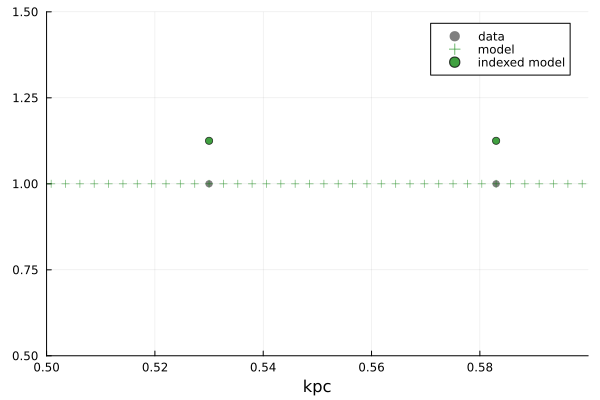

In [3]:
# Define constants in cgs units unless specified otherwise 
begin
    const γ     = 5.0/3.0             # Equation of State, Mono-atomic Ideal Gas
    const mu    = 0.6                 # Solar metallicity 
    const kb    = 1.380649e-16        # Boltzmann constant [erg/K]
    const kbKeV = 8.617333e-8         # Boltzmann constant [KeV/K]
    const Msun  = 1.9884754e33        # Solar mass [g]
    const yr    = 3.155692e7          # Year [s] 
    const kyr   = 3.155692e10         # Kiloyear [s] 
    const kpc   = 3.0856775e21        # Kiloparsec [cm]
    const pc    = 3.0856775e18        # Parsec [cm]
    const mp    = 1.6726219e-24       # Proton mass
    const kev_to_erg = 1.60219e-09    # Conversion of KeV to erg 

    # Even though we're using float64 and can handle cgs units (1/kpc^3), we'll still
    # convert to so-called code units in the system of ODEs. This helps the numerical solver. 

    const LENGTH_UNIT   = kpc 
    const TIME_UNIT     = kyr 
    const MASS_UNIT     = Msun 
    const VELOCITY_UNIT = LENGTH_UNIT / TIME_UNIT
    const DENSITY_UNIT  = MASS_UNIT / LENGTH_UNIT^3
    const PRESSURE_UNIT = MASS_UNIT * VELOCITY_UNIT^2 / LENGTH_UNIT^3 
    const ENERGY_UNIT   = MASS_UNIT * VELOCITY_UNIT^2 
end 

# Load in processed data 
begin 
    df = CSV.File(workingdirectory*"data/north_data.csv") |> DataFrame

    # Extract columns as arrays
    x_data = df[!, :z_N] |> collect
    T_data = df[!, :T_N] |> collect
    n_data = df[!, :n_N] |> collect
    A_data = df[!, :A_N] |> collect 
    dlogAdx_data = df[!, :dLA_N] |> collect
    K_data = T_data ./ n_data.^(2.0/3.0)
end 

# Define initial conditions, these are pre-calculated from the Python jupyter notebook 
begin 
    # These x-values are the same as the data's. 
    const x_i      = x_data[1]               # start
    const x_f      = x_data[end]             # stop
    const nx       = length(x_data)          # number steps between start and stop 
    const dx       = (x_f - x_i) / (nx-1)    # dx required  
    const xspan    = [x_i,x_f]
    const x_range  = range(start=x_i, stop=x_f, step=dx)
    const x_values = collect(x_range); 

    # This is the range and span we evaluate over for our models. 
    # This additional resolution is required to resolve cooling. 
    # fdx is the factor of model resolution relative to data resolution. 

    const fdx       = 20.0
    const dx2       = dx / fdx  
    const x_range2  = range(start=x_i,stop=x_f, step=dx2)
    const x_values2 = collect(x_range2)

    # indexes to compare the higher reslution to the data 
    indexes = 1:Int64(fdx):length(x_values2)

    println("Length of data  array: $(length(x_data))")
    println("Length of model array: $(length(x_range2))")

    # initial condition 
    # cgs 
    vInf = 1835e5   # v_Inf = 1853 km/s 

    v0 = vInf 
    n0 = n_data[1] 
    T0 = T_data[1] 
    ρ0 = n0 * mu * mp 
    P0 = n0 * kb * T0 
    u0 =  [v0,ρ0,P0]
    u0_CU = [v0/VELOCITY_UNIT,ρ0/DENSITY_UNIT,P0/PRESSURE_UNIT]
    xspan_CU = xspan / LENGTH_UNIT
    dx_CU = dx / LENGTH_UNIT 

    println("Ignore the y axis, its just to illustrate spacing, and confirm the indexing on the model and data is correct.")
    # Plot the resolutions for illustrative purposes. 
    # black is data resolution, blue is model resolution  
    plot(x_data,x_data ./ x_data,seriestype=:scatter,marker=:circle,markeralpha=0.5,xlims=(0.5,0.6),ylims=(0.5,1.5),c=:black,label="data")
    plot!(x_values2,x_values2 ./ x_values2,seriestype=:scatter,marker=:cross,c=:green,markeralpha=0.5,xlabel="kpc",label="model")
    plot!(x_values2[indexes], x_values2[indexes]./x_values2[indexes] .* 1.125,seriestype=:scatter,marker=:circle,c=:green,markeralpha=0.75,label="indexed model")
end 

In [10]:
println(xspan)
println(n_data[1])
println(T_data[1]/1e7)

[0.371, 2.65]
0.8437520685596535
0.61540302350947


# Load in trained neural ODE solutions, neural network parameters, and calculated loss. 

Then extract solutions alongside learned mass-loading function by reconstructing nn with trained parameters.

In [5]:
LOSS_ADAM_v1 = load_object(workingdirectory*"/output/north/v1/l_ADAM.jld2")
PRED_ADAM_v1 = load_object(workingdirectory*"/output/north/v1/sol_ADAM.jld2")
PARS_ADAM_v1 = load_object(workingdirectory*"/output/north/v1/p_ADAM.jld2")

LOSS_BFGS_v1 = load_object(workingdirectory*"/output/north/v1/l_BFGS.jld2")
PRED_BFGS_v1 = load_object(workingdirectory*"/output/north/v1/sol_BFGS.jld2")
PARS_BFGS_v1 = load_object(workingdirectory*"/output/north/v1/p_BFGS.jld2")

LOSS_ADAM_v2 = load_object(workingdirectory*"/output/north/v2/l_ADAM.jld2")
PRED_ADAM_v2 = load_object(workingdirectory*"/output/north/v2/sol_ADAM.jld2")
PARS_ADAM_v2 = load_object(workingdirectory*"/output/north/v2/p_ADAM.jld2")

LOSS_BFGS_v2 = load_object(workingdirectory*"/output/north/v2/l_BFGS.jld2")
PRED_BFGS_v2 = load_object(workingdirectory*"/output/north/v2/sol_BFGS.jld2")
PARS_BFGS_v2 = load_object(workingdirectory*"/output/north/v2/p_BFGS.jld2")

function extract_optimized_solutions(predictions,string)
    if string == "start"
        v = predictions[1][1,:] * VELOCITY_UNIT
        ρ = predictions[1][2,:] * DENSITY_UNIT
        P = predictions[1][3,:] * PRESSURE_UNIT
        n = ρ ./ (mu * mp)
        T = P ./ (n * kb)
        c = sqrt.(γ * P ./ ρ)
        K = T ./ n.^(2/3)
        M = v ./ c 
    elseif string == "end"
        v = predictions[end][1,:] * VELOCITY_UNIT
        ρ = predictions[end][2,:] * DENSITY_UNIT
        P = predictions[end][3,:] * PRESSURE_UNIT
        n = ρ ./ (mu * mp)
        T = P ./ (n * kb)
        c = sqrt.(γ * P ./ ρ)
        K = T ./ n.^(2/3)
        M = v ./ c 
    end
    return v, ρ, P, n, T, c, K, M
end 


# Grab prediction solutions for beginning and end of optimization iterations for final plots. 
# We'll loop through each iteration later below when making a movie. 

v1_adam_start, ρ1_adam_start, P1_adam_start, n1_adam_start, T1_adam_start, c1_adam_start, K1_adam_start, M1_adam_start = extract_optimized_solutions(PRED_ADAM_v1,"start");
v1_bfgs_end, ρ1_bfgs_end, P1_bfgs_end, n1_bfgs_end, T1_bfgs_end, c1_bfgs_end, K1_bfgs_end, M1_bfgs_end = extract_optimized_solutions(PRED_BFGS_v1,"end");

v2_adam_start, ρ2_adam_start, P2_adam_start, n2_adam_start, T2_adam_start, c2_adam_start, K2_adam_start, M2_adam_start = extract_optimized_solutions(PRED_ADAM_v2,"start");
v2_bfgs_end, ρ2_bfgs_end, P2_bfgs_end, n2_bfgs_end, T2_bfgs_end, c2_bfgs_end, K2_bfgs_end, M2_bfgs_end = extract_optimized_solutions(PRED_BFGS_v2,"end");


# Neural network

Ξ = 64
ann = Chain(  
    Dense(1, Ξ, swish),
    SkipConnection(Dense(Ξ, Ξ, swish), +),
    SkipConnection(Dense(Ξ, Ξ, swish), +),
    SkipConnection(Dense(Ξ, Ξ, swish), +),
    Dense(Ξ, 1, relu)  
)
p_init, re = Flux.destructure(ann)


# Define function to re-construct nn with trained parameters and wrap so it can be used for vectorized batched input
# Again, just grab beginning and end optimization states and calculate only for the range of inputs 

function μ_inferred(string,velocity) 
    if string == "adam"
        if velocity == "v1"
            params = Array(PARS_ADAM_v1[1])
        elseif velocity == "v2"
            params = Array(PARS_ADAM_v2[1])
        end
    elseif string == "bfgs"
        if velocity == "v1"
            params = Array(PARS_BFGS_v1[end])
        elseif velocity == "v2"
            params = Array(PARS_BFGS_v2[end])
        end
    end 
    Φ = re(params)
    Φ_wrapped = x->Float64.(Φ([x]))[1]
    return Φ_wrapped.(x_values2)
end
μ1_adam    = μ_inferred("adam","v1")
μ1_bfgs    = μ_inferred("bfgs","v1");

μ2_adam    = μ_inferred("adam","v2")  
μ2_bfgs    = μ_inferred("bfgs","v2")  



# Also load in simple spherical solution with no characterization of mass-loading or non-spherical flow. 

sph_sol = load_object(workingdirectory*"output/north/v1/PRED_sph.jld2")

function extract_cgs_solution(solution)
    v = solution[1,:] * VELOCITY_UNIT
    ρ = solution[2,:] * DENSITY_UNIT
    P = solution[3,:] * PRESSURE_UNIT
    n = ρ / (mu*mp)
    T = P ./ (n*kb)
    c = sqrt.(γ * P ./ ρ)
    K = T ./ n.^(2/3)
    M = v ./ c 
    return v, ρ, P, n, T, c, K, M
end 

v_sph, ρ_sph, P_sph, n_sph, T_sph, c_sph, K_sph, M_sph = extract_cgs_solution(sph_sol);

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(1 => 64, swish)  # 128 parameters
│   summary(x) = "1-element Vector{Float64}"
└ @ Flux ~/.julia/packages/Flux/pR3k3/src/layers/stateless.jl:60


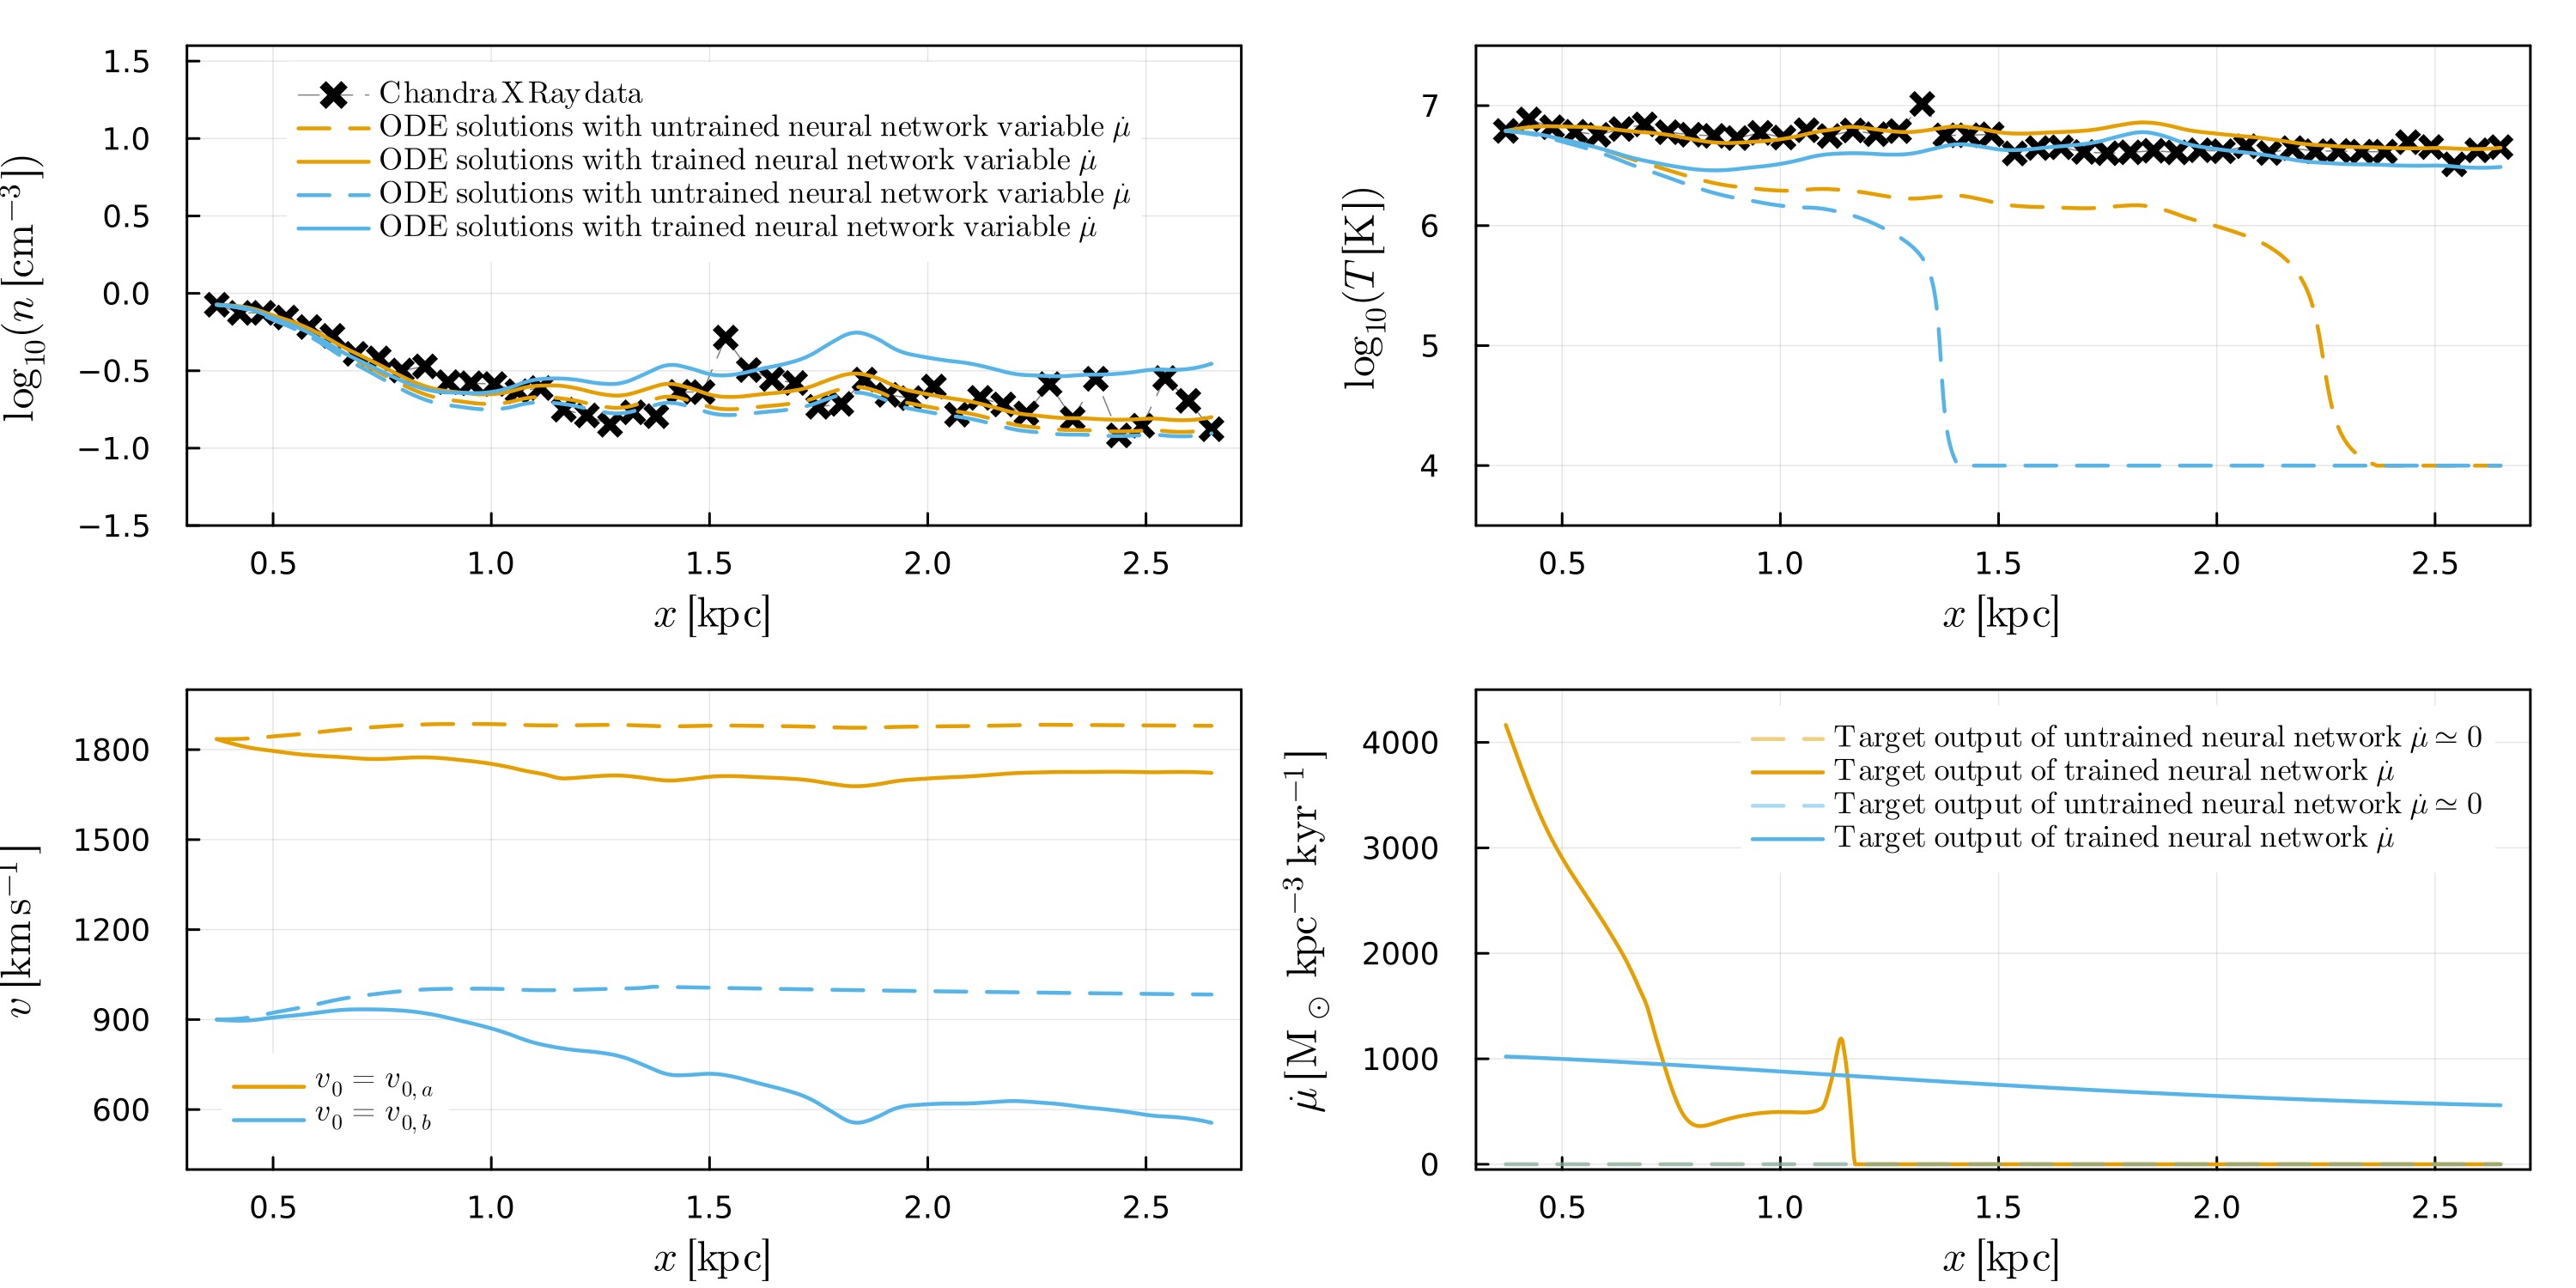

In [32]:
begin 

    framestyle = :box 
    legendfontsize = 8
    dpi = 300
    
    
    nlog_min = -1.5
    nlog_max =  1.6
    nlog_bounds = (nlog_min,nlog_max)
    
    Tlog_min =  3.5 
    Tlog_max =  7.5
    Tlog_bounds = (Tlog_min,Tlog_max)
    
    v_min = 400
    v_max = 2000
    v_bounds = (v_min,v_max)
    
    μ_min = -50
    μ_max = 4500
    μ_bounds = (μ_min,μ_max)
    
    xlabel  = L"$x\ \mathrm{[kpc]}$"
    ylabel1 = L"$\log_{10}(n \ \mathrm{[cm^{-3}]})$"
    ylabel2 = L"$\log_{10}(T \ \mathrm{[K]})$"
    ylabel3 = L"$v \ \mathrm{[km\,s^{-1}]}$"
    ylabel4 = L"$\dot{\mu} \ \mathrm{[M_\odot \, kpc^{-3} \, kyr^{-1}]}$"
    
    data_label = L"$\mathrm{Chandra \, X \, Ray \, data}$"
    easy_label = L"$\mathrm{spherical \ model \ with \ no \ mass \, loading \ term }$"
    adam_v1_label = L"$\mathrm{ODE \ solutions \ with \ untrained \ neural \ network \ variable \ \dot{\mu}  }$"
    bfgs_v1_label = L"$\mathrm{ODE \ solutions \ with \ trained \ neural \ network \ variable \ \dot{\mu}  }$"
    
    adam_v2_label = L"$\mathrm{ODE \ solutions \ with \ untrained \ neural \ network \ variable \ \dot{\mu}  }$"
    bfgs_v2_label = L"$\mathrm{ODE \ solutions \ with \ trained \ neural \ network \ variable \ \dot{\mu}  }$"
    
    sph_μ_label  = L"$\mathrm{no \ mass \, loading \ term}$"
    adam_μ1_label = L"$\mathrm{Target \ output \ of \ untrained \ neural \ network} \ \dot{\mu} \simeq 0 $"
    bfgs_μ1_label = L"$\mathrm{Target \ output \ of \ trained \ neural \ network } \  \dot{\mu} $"
    adam_μ2_label = L"$\mathrm{Target \ output \ of \ untrained \ neural \  network} \ \dot{\mu} \simeq 0 $"
    bfgs_μ2_label = L"$\mathrm{Target \ output \ of \ trained \ neural \ network } \  \dot{\mu} $"
    
    Mdot1_label = L"$M_\mathrm{load}/M_\mathrm{wind} = 0.06$"
    Mdot2_label = L"$M_\mathrm{load}/M_\mathrm{wind} = 0.93$"
    
    v1_label = L"$v_0 = v_{0,a}$"
    v2_label = L"$v_0 = v_{0,b}$"
    
    data_c = :black
    model_palette = :okabe_ito
    easy_c = 7
    v1_c = 1 
    v2_c = 2 
    adam_ls = :dash
    
    p1 = plot(x_data,log10.(n_data),
            xlabel=xlabel,ylabel=ylabel1,label=data_label,ylim=nlog_bounds,framestyle=framestyle,
            seriestype=:scatter,marker=:x,msw=3,markeralpha=1.0,line=:path,ls=:dash,lw=0.5,linealpha=0.5,c=data_c,
            legend=:top,legendfontsize=legendfontsize,fg_legend = :transparent,dpi=dpi
            )
    plot!(x_values2,log10.(n1_adam_start),palette=model_palette,lw=1.5,label=adam_v1_label,c=v1_c,ls=adam_ls)
    plot!(x_values2,log10.(n1_bfgs_end),palette=model_palette,lw=1.5,label=bfgs_v1_label,c=v1_c)
    
    plot!(x_values2,log10.(n2_adam_start),palette=model_palette,lw=1.5,label=adam_v2_label,c=v2_c,ls=adam_ls)
    plot!(x_values2,log10.(n2_bfgs_end),palette=model_palette,lw=1.5,label=bfgs_v2_label,c=v2_c)

    p2 = plot(x_data,log10.(T_data),
            xlabel=xlabel,ylabel=ylabel2,label=data_label,ylim=Tlog_bounds,framestyle=framestyle,
            seriestype=:scatter,marker=:x,msw=3,markeralpha=1.0,line=:path,ls=:dash,lw=0.5,linealpha=0.5,c=data_c,
            legend=false
            )
    plot!(x_values2,log10.(T1_adam_start),palette=model_palette,lw=1.5,label=adam_v1_label,c=v1_c,ls=adam_ls)
    plot!(x_values2,log10.(T1_bfgs_end),palette=model_palette,lw=1.5,label=bfgs_v1_label,c=v1_c)
    
    plot!(x_values2,log10.(T2_adam_start),palette=model_palette,lw=1.5,label=adam_v2_label,c=v2_c,ls=adam_ls)
    plot!(x_values2,log10.(T2_bfgs_end),palette=model_palette,lw=1.5,label=bfgs_v2_label,c=v2_c)


    p3 = 
    plot(x_values2,v1_adam_start/1e5,xlabel=xlabel,ylabel=ylabel3,palette=model_palette,lw=1.5,label=false,c=v1_c,ls=adam_ls,ylim=v_bounds,framestyle=framestyle,legendfontsize=legendfontsize,fg_legend = :transparent)
    plot!(x_values2,v1_bfgs_end/1e5,palette=model_palette,lw=1.5,c=v1_c,label=v1_label)
    
    plot!(x_values2,v2_adam_start/1e5,palette=model_palette,lw=1.5,label=false,c=v2_c,ls=adam_ls)
    plot!(x_values2,v2_bfgs_end/1e5,palette=model_palette,lw=1.5,label=v2_label,c=v2_c)
    
    p4 =  
    plot(x_values2,μ1_adam,xlabel=xlabel,ylabel=ylabel4,palette=model_palette,lw=1.5,label=adam_μ1_label,c=v1_c,ls=adam_ls,ylim=μ_bounds,framestyle=framestyle,alpha=0.5,
        legend=:topright,legendfontsize=legendfontsize,fg_legend = :transparent,dpi=dpi)
    plot!(x_values2,μ1_bfgs,palette=model_palette,lw=1.5,label=bfgs_μ1_label,c=v1_c)
    plot!(x_values2,μ2_adam,palette=model_palette,lw=1.5,label=adam_μ2_label,c=v2_c,ls=adam_ls,alpha=0.5)
    plot!(x_values2,μ2_bfgs,palette=model_palette,lw=1.5,label=bfgs_μ2_label,c=v2_c)
    
    annotate!

    
    combined_plot = plot(p1, p2, p3, p4, layout=(2, 2),size=(1000,500),margin=2.5mm)
    savefig(combined_plot,workingdirectory*"plots/north_fits.png")
    display(combined_plot)
end 

Integrate $\dot{\mu}$ over all $x$. 

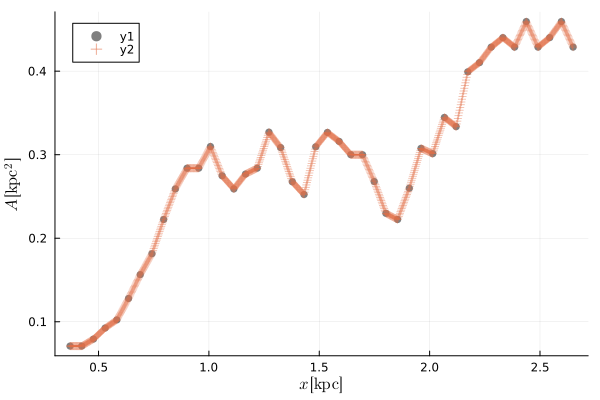

In [6]:
begin
    function Array_interpolation(x, x_values, Array)
        idx = searchsortedlast(x_values, x)

        # If x is outside the range of x_values, return the edge values of Array
        if idx == 0
            return Array[1]
        elseif idx == length(x_values)
            return Array[end]
        end

        # Calculate the slope between the two surrounding points
        slope = (Array[idx+1] - Array[idx]) / (x_values[idx+1] - x_values[idx])

        # Return the interpolated value
        return Array[idx] + slope * (x - x_values[idx])
    end
     # Plot the surface area expansion rate for the higher resolution spatial points 
     interp_values = [Array_interpolation(x, x_data, A_data) for x in x_range2]
    
     plot(x_data,A_data/(LENGTH_UNIT^2),seriestype=:scatter,market=:circle,markeralpha=0.5,c=:black,xlabel=L"$x\, \mathrm{[kpc]}$",ylabel=L"$ A \, \mathrm{[kpc^{2}]}$")
     plot!(x_range2,interp_values/(LENGTH_UNIT^2),seriestype=:scatter,marker=:cross,markeralpha=0.5)
end

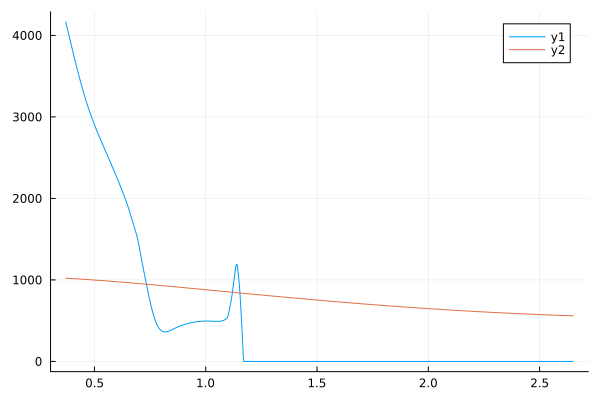

In [31]:
plot(x_values2,μ1_bfgs)
plot!(x_values2,μ2_bfgs)

In [42]:
function simpsons_rule(x, y)
    if length(x) < 3
        error("Need at least three data points for Simpson's 1/3 rule!")
    end

    if (length(x) - 1) % 2 != 0
        error("Number of intervals must be even for Simpson's 1/3 rule!")
    end

    h = (x[end] - x[1]) / (length(x) - 1)
    integral = y[1] + y[end]

    for i = 2:length(y)-1
        if i % 2 == 0
            integral += 4 * y[i]
        else
            integral += 2 * y[i]
        end
    end

    integral *= h/3
    return integral
end


x = 2:0.1:5
y = x.^2
result = simpsons_rule(x, y)
println(result)

# This is correct. 125/3 - 8/3 = 39 

39.0


In [43]:

# Integrand is: (A * mudot )
    
Integrand1 =  μ1_bfgs  .* (interp_values/(kpc^2))  
Integrand2 =  μ2_bfgs  .* (interp_values/(kpc^2))  
    
Mdot1 = simpsons_rule(x_values2, Integrand1)
Mdot2 = simpsons_rule(x_values2, Integrand2)
    
println("Mdot1 is $Mdot1 [Msun/kyr], or $(Mdot1/1000.0) [Msun/yr]")
println("Mdot2 is $Mdot2 [Msun/kyr], or $(Mdot2/1000.0) [Msun/yr]")

Mdot1 is 150.96509053188427 [Msun/kyr], or 0.15096509053188428 [Msun/yr]
Mdot2 is 473.504201197289 [Msun/kyr], or 0.473504201197289 [Msun/yr]


In [44]:
β = 0.6264125474298924
SFR = 6

MdotHot = β * SFR 

M1_wind  = (v1_bfgs_end[1] * (interp_values[1]) * ρ1_bfgs_end[1])/(Msun/yr)

M2_wind  = (v2_bfgs_end[1] * (interp_values[1]) * ρ2_bfgs_end[1])/(Msun/yr)


println("CC85 M_dot is $MdotHot Msun/yr ")
println("M_wind with v1 is $M1_wind Msun/yr ")
println("M_wind with v2 is $M2_wind Msun/yr ")

println("")
println("Mass-loading result:")
println("Ratio for v1 of M_load / M_wind is $((Mdot1/1000.0)/M1_wind)")
println("Ratio for v2 of M_load / M_wind is $((Mdot2/1000.0)/M2_wind)")

CC85 M_dot is 3.7584752845793545 Msun/yr 
M_wind with v1 is 1.6642696151516159 Msun/yr 
M_wind with v2 is 0.8162630265048797 Msun/yr 

Mass-loading result:
Ratio for v1 of M_load / M_wind is 0.09070951554813508
Ratio for v2 of M_load / M_wind is 0.5800877729630429


# Plot of NN learning 

v1 and v2 converged after different numbers of iterations in BFGS second round, therefore, each will need a different for loop

In [11]:
TOTAL_LOSS_v1 = vcat(LOSS_ADAM_v1,LOSS_BFGS_v1)
TOTAL_PRED_v1 = vcat(PRED_ADAM_v1,PRED_BFGS_v1)
TOTAL_PARS_v1 = vcat(PARS_ADAM_v1,PARS_BFGS_v1)
TOTAL_ITER_v1 = collect(1:length(TOTAL_PARS_v1))
    
TOTAL_LOSS_v2 = vcat(LOSS_ADAM_v2,LOSS_BFGS_v2)
TOTAL_PRED_v2 = vcat(PRED_ADAM_v2,PRED_BFGS_v2)
TOTAL_PARS_v2 = vcat(PARS_ADAM_v2,PARS_BFGS_v2)
TOTAL_ITER_v2 = collect(1:length(TOTAL_PARS_v2))


12

In [45]:
tester = Array([2,1])

for i in 1:length(TOTAL_PARS_v1)
    
    iminus1 = i-1
    
    v_i = TOTAL_PRED_v1[i][1,:] * VELOCITY_UNIT
    ρ_i = TOTAL_PRED_v1[i][2,:] * DENSITY_UNIT
    P_i = TOTAL_PRED_v1[i][3,:] * PRESSURE_UNIT
    n_i = ρ_i ./ (mu * mp)
    T_i = P_i ./ (n_i * kb)
    c_i = sqrt.(γ * P_i ./ ρ_i)
    K_i = T_i ./ n_i.^(2/3)
    M_i = v_i ./ c_i 
    
    # Grab the parameters of the NN for the given epoch iteration

    params = Array(TOTAL_PARS_v1[i])    
    Φ = re(params)
    Φ_wrapped = x->Float64.(Φ([x]))[1]

    μdot_i = Φ_wrapped.(x_values2)
    
    
    
    
    framestyle = :box 
    legendfontsize = 8
    dpi = 300
    
    
    nlog_min = -2.0 
    nlog_max =  1.25
    nlog_bounds = (nlog_min,nlog_max)
    
    Tlog_min =  3.5 
    Tlog_max =  7.5
    Tlog_bounds = (Tlog_min,Tlog_max)
    
    
    μ_min = -50
    μ_max = 4500
    μ_bounds = (μ_min,μ_max)
    
    xlabel  = L"$x\ \mathrm{[kpc]}$"
    ylabel1 = L"$\log_{10}(n \ \mathrm{[cm^{-3}]})$"
    ylabel2 = L"$\log_{10}(T \ \mathrm{[K]})$"
    ylabel4 = L"$\dot{\mu} \ \mathrm{[M_\odot \, kpc^{-3} \, kyr^{-1}]}$"
    
    data_label = L"$\mathrm{Chandra \, X \, Ray \, data}$"
    
    adam_v1_label = L"$\mathrm{untrained \ } A(x) \mathrm{ \  model \ prediction , } v_0 \simeq v_\infty , \ \dot{\mu} \simeq 0 $"
    bfgs_v1_label = L"$\mathrm{trained \ } A(x) \mathrm{  \ model \ prediction , } v_0 \simeq v_\infty $"
    
    adam_v2_label = L"$\mathrm{untrained \ } A(x) \mathrm{ \  model \ prediction , } v_0 \simeq v_\infty/2 , \ \dot{\mu} \simeq 0 $"
    bfgs_v2_label = L"$\mathrm{trained \ } A(x) \mathrm{  \ model \ prediction , } v_0 \simeq v_\infty/2 $"
    
   
    adam_μ1_label = L""

    Mdot1_label = L"$M_\mathrm{load}/M_\mathrm{wind} = 0.06$"
    Mdot2_label = L"$M_\mathrm{load}/M_\mathrm{wind} = 0.93$"
    
    
    data_c = :black
    model_palette = :okabe_ito
    easy_c = 7
    v1_c = 1 
    v2_c = 2 
    adam_ls = :dash
    
    ylabel_Loss = L"$\mathrm{normalized \ loss}$"
    xlabel_Loss = L"$\mathrm{iterations}$"
    
    p1 = plot(x_data,log10.(n_data),
            xlabel=xlabel,ylabel=ylabel1,label=data_label,ylim=nlog_bounds,framestyle=framestyle,
            seriestype=:scatter,marker=:x,msw=3,markeralpha=0.6,line=:path,ls=:dash,lw=0.5,linealpha=0.5,c=data_c,
            legend=:top,legendfontsize=legendfontsize,fg_legend = :transparent,dpi=dpi
            )
    plot!(x_values2,log10.(n_i),palette=model_palette,lw=1.5,label="",c=v1_c)


    p2 = plot(x_data,log10.(T_data),
            xlabel=xlabel,ylabel=ylabel2,label=data_label,ylim=Tlog_bounds,framestyle=framestyle,
            seriestype=:scatter,marker=:x,msw=3,markeralpha=0.6,line=:path,ls=:dash,lw=0.5,linealpha=0.5,c=data_c,
            legend=false
            )
    plot!(x_values2,log10.(T_i),palette=model_palette,lw=1.5,label=adam_v1_label,c=v1_c)

    

    p3 = plot(x_values2,μdot_i,xlabel=xlabel,ylabel=ylabel4,palette=model_palette,lw=1.5,c=v1_c,label="",ylim=μ_bounds,framestyle=framestyle,
        legend=:topright,legendfontsize=legendfontsize,fg_legend = :transparent,dpi=dpi)
    annotate!(2.2, 4000, "iteration $iminus1", :black)

    p4 = plot(TOTAL_ITER_v1[1:i],TOTAL_LOSS_v1[1:i]/maximum(TOTAL_LOSS_v1),label="",yscale=:log10,xlabel=xlabel_Loss,ylabel=ylabel_Loss,palette=model_palette,lw=1.5,c=v1_c,framestyle=framestyle)
    
    combined_plot = plot(p1, p2, p3, p4, layout=(2, 2),size=(1000,500),margin=4mm)
    savefig(combined_plot,workingdirectory*"plots/iters/$iminus1.png")
    #display(combined_plot) 
end

